In [106]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns


Extraction des fichier csv 

In [107]:
train__set_features = pd.read_csv("training_set_features.csv")
test = pd.read_csv("test_set_features.csv")
train__set_features.shape

train__set_labels = pd.read_csv("training_set_labels.csv")

y_h1n1 = train__set_labels['h1n1_vaccine']
y_seasonal = train__set_labels['seasonal_vaccine']


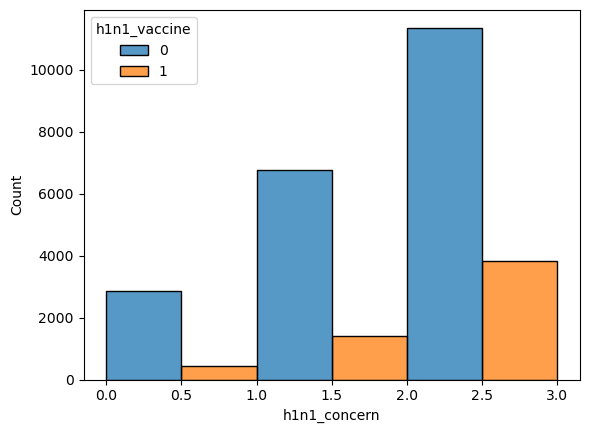

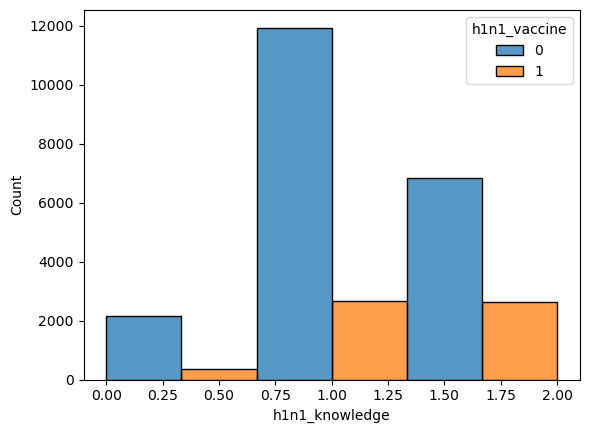

In [120]:
train = pd.concat([train__set_features, y_h1n1, y_seasonal], axis=1)

def histshow(X, col, target):
    sns.histplot(data=X, x=X[col], bins=3, hue="h1n1_vaccine", multiple="dodge")
    plt.show()

histshow(train,"h1n1_concern", "h1n1_vaccine")
train.select_dtypes(include=np.number).columns
histshow(train,"h1n1_knowledge", "h1n1_vaccine")

On va gerer les valeurs manquantes et les valeurs categoriels 

In [85]:
train.select_dtypes(include='object').isna().sum()


# la moitié de employement _industry et _occupation est manquante 
train['employment_occupation'].value_counts()

# essayer de creer catagorie big industrie // small industrie 

def employment_cat(X):
    small_jobs = train['employment_occupation'].value_counts() < 500
    small_industries = train['employment_industry'].value_counts() < 500
    X.loc[X['employment_occupation'].isin(small_jobs.index[small_jobs]), 'employment_occupation'] = 'small_job'
    X.loc[X['employment_industry'].isin(small_industries.index[small_industries]), 'employment_industry'] = 'small_industry'
    return X 

train = employment_cat(train)
test = employment_cat(test)

print(test.shape, train.shape)

(26708, 36) (26707, 38)


In [86]:
col = train.select_dtypes(exclude=(np.number)).columns

train = pd.get_dummies(train, columns=col)
test = pd.get_dummies(test, columns=col)

print(test.shape, train.shape)

(26708, 106) (26707, 84)


Creation des colonnes dans le cas ou la categorie n'était pas le test set 

In [87]:


def train_test_col_norm(train, test):
    for col in train.columns: 
        if not(col in test.columns) and not(col in ['seasonal_vaccine', 'h1n1_vaccine']):
            test[col] = pd.Series(np.zeros(test.shape[0]), name=col)


    for col in test.columns:
        if not(col in train.columns):
            train[col] = pd.Series(np.zeros(train.shape[0]), name=col)
    return train,test
train, test = train_test_col_norm(train, test)


(26708, 106) (26707, 84)
(26708, 108) (26707, 84)
(26708, 108) (26707, 110)


Estimation des valeurs manquantes grace aux KNN 


In [88]:

# essayer d'utiliser le test set pour les NA
 
from sklearn.neighbors import KNeighborsRegressor

def manage_na(X,na_col): 
    X = X.copy()
    numerical = X.select_dtypes(np.number)
    non_na_columns = numerical.loc[:,numerical.isna().sum() == 0].columns
    X_train = numerical.loc[numerical[na_col].isna() == False,non_na_columns]
    y_train = numerical.loc[numerical[na_col].isna() == False,na_col]
    X_na = numerical.loc[numerical[na_col].isna() == True, non_na_columns]
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    y_na = knn.predict(X_na)
    X.loc[X[na_col].isna() == True, na_col] = y_na
    
    return X 

In [89]:
cond = train.corr()['seasonal_vaccine'].apply(abs).sort_values() > 0.20


nulls = train[cond.index[cond]].isna().sum() > 0


for col in nulls[nulls == True].index:
    train = manage_na(train, col)

nulls_test = test.isna().sum() > 0

for col in nulls_test[nulls_test == True].index:
    test = manage_na(test, col)

corr = train.corr()['seasonal_vaccine'].apply(abs).sort_values()


In [90]:
nulls = train.isna().sum().sort_values() > 0


In [91]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split


X = train


params = {
    "n_estimators": np.arange(7, 10,1), 
    "max_depth": np.arange(7, 10, 1),
    "min_samples_leaf": np.arange(12,15 , 1), 
}
grid = GridSearchCV(GradientBoostingRegressor(), params, cv=5)

nulls = X.isna().sum() > 0 

for col in nulls[nulls == True].index:
    X = manage_na(X, col)


X = X.drop(["h1n1_vaccine", "seasonal_vaccine"], axis=1).sort_index(axis=1)
test = test.sort_index(axis=1)

X_train, X_test, y_train, y_test_seas = train_test_split(X, y_seasonal,  test_size=0.2, random_state=32,)

# grid.fit(X_train, y_train)
# grid.best_params_


In [92]:
# model = RandomForestRegressor(max_depth=9,min_samples_leaf=13, n_estimators=9)
model = GradientBoostingRegressor(max_depth=9,min_samples_leaf=14, n_estimators=9)
model.fit(X_train, y_train)

y_seasonal_predict = model.predict(test)
y_seasonal_predict_test = model.predict(X_test)

# rf.score(X_test, y_test_seas)
y_seasonal_predict.mean()
y_seasonal_predict.shape


(26708,)

In [93]:
X_train, X_test, y_train, y_test_h1n1 = train_test_split(X, y_h1n1,  test_size=0.2, random_state=32,)

# rf = RandomForestRegressor()
model = GradientBoostingRegressor(max_depth=8,min_samples_leaf=13, n_estimators=9)
model.fit(X_train, y_train)


grid.fit(X_train, y_train)
print(grid.best_params_)



y_h1n1_predict = model.predict(test)
y_h1n1_predict_test = model.predict(X_test)


print(model.score(X_test, y_test_h1n1))
y_h1n1_predict.mean()

result = pd.concat([test["respondent_id"], pd.Series(y_h1n1_predict, name="h1n1_vaccine"), pd.Series(y_seasonal_predict, name="seasonal_vaccine")], axis=1)
result.to_csv("result_employment.csv", index=False)




{'max_depth': 9, 'min_samples_leaf': 14, 'n_estimators': 9}
0.24795707660155997


In [94]:
sub_format = pd.read_csv("submission_format.csv")

In [95]:
from sklearn.metrics import roc_auc_score

y_true = np.hstack([y_test_h1n1, y_test_seas])
y_score = np.hstack([y_h1n1_predict_test, y_seasonal_predict_test])


roc_auc_score(y_true, y_score)


0.8517982100230852